In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import umap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset


plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
num_rows = int(131072 / 2)
num_features = 128

# add boolean features

x_data, y_data = make_classification(n_samples=num_rows, n_features=num_features, n_clusters_per_class=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.25, stratify=y_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_validation = scaler.transform(x_validation)

In [3]:
#

In [4]:
class Data(Dataset):
	
	def __init__(self, data, pairs):
		self.data = data
		self.pairs = pairs
	
	def __len__(self):
		return len(self.pairs)
	
	def __getitem__(self, idx):
		index1, index2, label = self.pairs[idx]
		return self.data[index1], self.data[index2], label

In [5]:
def generate_pairs_and_loader(x, y, batch_size):
	zero_class_indices = np.where(y == 0)[0]
	one_class_indices = np.where(y == 1)[0]
	
	zero_class_pairs = np.random.choice(zero_class_indices, size=(int(len(zero_class_indices) / 2), 2), replace=False)
	one_class_pairs = np.random.choice(one_class_indices, size=(int(len(one_class_indices) / 2), 2), replace=False)
	
	print(f'zero_class_pairs: {zero_class_pairs.shape}')
	print(f'one_class_pairs: {one_class_pairs.shape}')
	print()
	
	pairs = [(zero_class_pairs[i, 0], zero_class_pairs[i, 1], 0) for i in range(len(zero_class_pairs))] + \
	        [(one_class_pairs[i, 0], one_class_pairs[i, 1], 1) for i in range(len(one_class_pairs))]
	
	data = Data(x, pairs)
	data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
	
	return data_loader


batch_size = 8
train_data_loader = generate_pairs_and_loader(x_train, y_train, batch_size)
test_data_loader = generate_pairs_and_loader(x_test, y_test, batch_size)
validation_data_loader = generate_pairs_and_loader(x_validation, y_validation, batch_size)

zero_class_pairs: (12290, 2)
one_class_pairs: (12286, 2)

zero_class_pairs: (3072, 2)
one_class_pairs: (3071, 2)

zero_class_pairs: (1024, 2)
one_class_pairs: (1024, 2)


In [6]:
#

In [7]:
# add triplet loss

class ContrastiveLoss(nn.Module):
	
	def __init__(self, margin=1.0):
		super(ContrastiveLoss, self).__init__()
		self.margin = margin
	
	def forward(self, output1, output2, label):
		output1 = F.normalize(output1, p=2, dim=-1)
		output2 = F.normalize(output2, p=2, dim=-1)
		
		cosine_similarity = F.cosine_similarity(output1, output2)
		loss = (1 - label) * torch.pow(cosine_similarity, 2) + label * torch.pow(torch.clamp(self.margin - cosine_similarity, min=0.0), 2)
		
		return loss.mean()

In [8]:
loss_fn = ContrastiveLoss()

In [9]:
#

In [10]:
class SiameseNetwork(nn.Module):
	
	def __init__(self, num_bool_features, num_numerical_features):
		super(SiameseNetwork, self).__init__()
		self.bool_net = nn.Sequential(
				nn.Linear(num_bool_features, num_bool_features // 2),
				nn.ReLU(),
				)
		self.num_net = nn.Sequential(
				nn.Linear(num_numerical_features, num_numerical_features // 2),
				nn.ReLU(),
				)
		
		total_size = num_bool_features // 2 + num_numerical_features // 2
		self.siamese_net = nn.Sequential(
				nn.Linear(total_size, total_size // 2),
				nn.ReLU(),
				nn.BatchNorm1d(total_size // 2),
				)
	
	def forward(self, bool_input, num_input):
		bool_output = self.bool_net(bool_input)
		num_output = self.num_net(num_input)
		combined_output = torch.cat((bool_output, num_output), dim=1)
		output = self.siamese_net(combined_output)
		return output

In [11]:
model = SiameseNetwork(num_features)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
#

In [13]:
def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=8, early_stopping_patience=2):
	train_losses = []
	test_losses = []
	best_test_loss = float('inf')
	patience_counter = 0
	
	for epoch in range(epochs):
		# Training phase
		model.train()
		train_running_loss = 0.0
		for data1, data2, labels in train_dataloader:
			data1 = data1.float()
			data2 = data2.float()
			
			optimizer.zero_grad()
			outputs1, outputs2 = model(data1, data2)
			loss = loss_fn(outputs1, outputs2, labels)
			loss.backward()
			optimizer.step()
			train_running_loss += loss.item()
		
		train_loss = train_running_loss / len(train_dataloader)
		train_losses.append(train_loss)
		
		# Validation phase
		model.eval()
		test_running_loss = 0.0
		with torch.no_grad():
			for data1, data2, labels in test_dataloader:
				data1 = data1.float()
				data2 = data2.float()
				
				outputs1, outputs2 = model(data1, data2)
				loss = loss_fn(outputs1, outputs2, labels)
				test_running_loss += loss.item()
			
			test_loss = test_running_loss / len(test_dataloader)
			test_losses.append(test_loss)
			
			# Early stopping
			if test_loss < best_test_loss:
				best_test_loss = test_loss
				patience_counter = 0
			
			else:
				patience_counter += 1
				
				if patience_counter >= early_stopping_patience:
					print(f'Early stopping at epoch {epoch + 1}...')
					break
		
		print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
	
	return model

In [14]:
model = train(train_data_loader, test_data_loader, model, loss_fn, optimizer, epochs=128, early_stopping_patience=8)

Epoch 1, Train Loss: 0.0912459731718324, Test Loss: 0.05716274973383406
Epoch 2, Train Loss: 0.07768475300023663, Test Loss: 0.05395501582461293
Epoch 3, Train Loss: 0.07446317415845745, Test Loss: 0.054633479678765674
Epoch 4, Train Loss: 0.07240442583853716, Test Loss: 0.053004597115129094
Epoch 5, Train Loss: 0.07080756092924882, Test Loss: 0.05312392080698677
Epoch 6, Train Loss: 0.06873348317731143, Test Loss: 0.04936373982824686
Epoch 7, Train Loss: 0.06896808629494444, Test Loss: 0.04848408441345479
Epoch 8, Train Loss: 0.06778937925878381, Test Loss: 0.05009505654864673
Epoch 9, Train Loss: 0.06730080341882665, Test Loss: 0.05205373676775101
Epoch 10, Train Loss: 0.06885241132014623, Test Loss: 0.05128015050013346
Epoch 11, Train Loss: 0.06750527864816529, Test Loss: 0.04876714540478133
Epoch 12, Train Loss: 0.06633541984168308, Test Loss: 0.052004162142111454
Epoch 13, Train Loss: 0.06566983721078638, Test Loss: 0.05612667658169812
Epoch 14, Train Loss: 0.06645283273011653, Te

In [15]:
#

In [17]:
input_tensor = torch.tensor(x_validation, dtype=torch.float)

with torch.no_grad():
	embeddings = model.net(input_tensor).numpy()

In [ ]:
def visualize_embeddings(embeddings, labels):
	umap_model = umap.UMAP(metric='cosine')
	embeddings = umap_model.fit_transform(embeddings)
	
	plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral', s=1, alpha=1.00)
	plt.show()

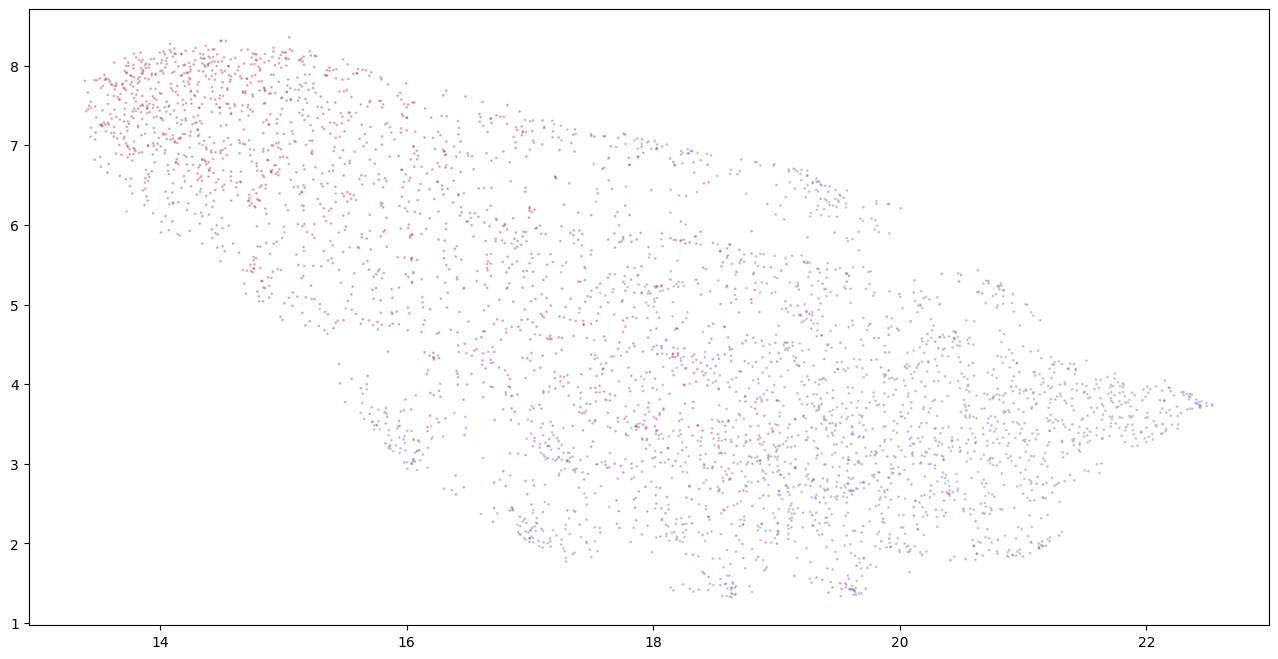

In [18]:
visualize_embeddings(embeddings, y_validation)